<a href="https://colab.research.google.com/github/norulwahab/nor_python_ml/blob/main/Malaria_cnn_Custom_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten, InputLayer,BatchNormalization, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from tensorflow.keras.metrics import BinaryAccuracy, FalseNegatives,FalsePositives, TruePositives, TrueNegatives, Recall, Precision, AUC

In [15]:
dataset, dataset_info=tfds.load('malaria',with_info=True, as_supervised=True,shuffle_files=True, split=['train'])

In [16]:
def splits(dataset, TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))

  return train_dataset,val_dataset,test_dataset

In [17]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset,val_dataset,test_dataset = splits(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)


##Data Visualization##

In [18]:
#for i, (image, label) in enumerate(train_dataset.take(20)):
#  plt.subplot(4,5,i+1)
#  plt.imshow(image)
 # plt.title(dataset_info.features['label'].int2str(label))
  #plt.axis('off')

##Processing##


In [19]:
IMAGE_SIZE=224
def resize_rescale(image,label):
  return tf.image.resize(image, (IMAGE_SIZE,IMAGE_SIZE))/255.0,label

In [20]:
train_dataset=train_dataset.map(resize_rescale)
val_dataset=val_dataset.map(resize_rescale)
test_dataset=test_dataset.map(resize_rescale)
# for image,label in train_dataset.take(1):
#   print(image,label)

In [21]:
train_dataset=train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [22]:
val_dataset=val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [23]:
test_dataset=test_dataset.batch(1)

##Model Creation and Training


In [24]:
class Custom_Dense(Layer):
  def __init__(self, output_units,activation):
    super(Custom_Dense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer = 'random_normal', trainable =True)
    self.b = self.add_weight(shape = (self.output_units,), initializer = 'random_normal', trainable = True)

  def call(self,input_features):
    pre_output = tf.matmul(input_features,self.w) + self.b
    if (self.activation == 'relu'):
      return tf.nn.relu(pre_output)
    elif (self.activation == 'sigmoid'):
      return tf.math.sigmoid(pre_output)
    else:
      return pre_output

In [25]:
lenet_custom_model = tf.keras.models.Sequential([
                                      InputLayer(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)),

                                      Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
                                      BatchNormalization(),
                                      MaxPooling2D(pool_size=2, strides=2),

                                      Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
                                      BatchNormalization(),
                                      MaxPooling2D(pool_size=2, strides=2),

                                      Flatten(),
                                      Custom_Dense(100, activation='relu'),
                                      BatchNormalization(),
                                      Custom_Dense(10, activation='relu'),
                                      BatchNormalization(),

                                      Custom_Dense(1, activation='sigmoid')
                                      ])
lenet_custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [26]:
metrics =[BinaryAccuracy(name ='accuracy'), FalseNegatives(name ='fp'),FalsePositives(name ='fn'), TruePositives(name ='tp'),
          TrueNegatives(name ='tn'), Recall(name ='recall'), Precision(name ='precision'), AUC(name ='auc')]

In [27]:
lenet_custom_model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(),metrics=metrics)

In [28]:
history= lenet_custom_model.fit(train_dataset,validation_data= val_dataset,epochs=20,verbose=1)

<ipython-input-29-2e8b6b8ce6d7>:6: UserWarning: The label '_' of 'o' starts with '_'. It is thus excluded from the legend.
  plt.legend('Training_Loss','Validation_Loss')
<ipython-input-29-2e8b6b8ce6d7>:6: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Training_Loss','Validation_Loss')


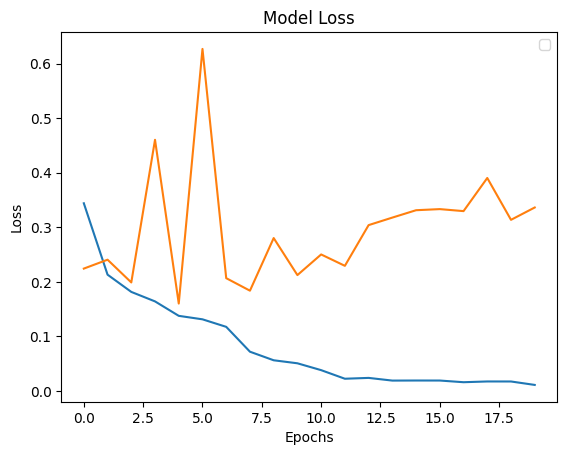

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend('Training_Loss','Validation_Loss')
plt.show()

<ipython-input-17-857611124634>:6: UserWarning: The label '_' of 'c' starts with '_'. It is thus excluded from the legend.
  plt.legend('Training_Accuracy','Validation_Accuracy')
<ipython-input-17-857611124634>:6: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Training_Accuracy','Validation_Accuracy')


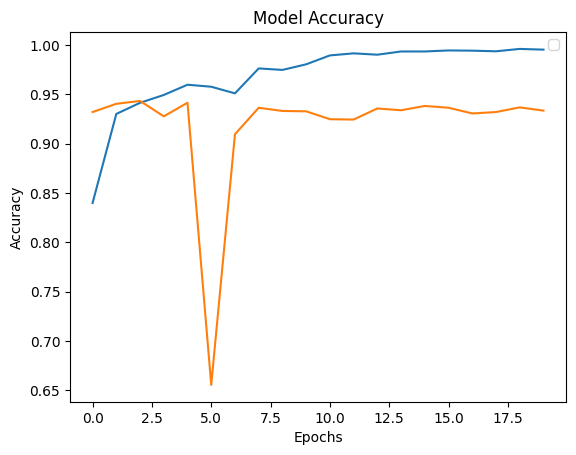

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend('Training_Accuracy','Validation_Accuracy')
plt.show()

In [30]:
lenet_custom_model.evaluate(test_dataset)

2757/2757 [==============================] - 26s 5ms/step - loss: 0.3703 - accuracy: 0.9242 - fp: 106.0000 - fn: 103.0000 - tp: 1256.0000 - tn: 1292.0000 - recall: 0.9222 - precision: 0.9242 - auc: 0.9637


[0.370254784822464,
 0.9241929650306702,
 106.0,
 103.0,
 1256.0,
 1292.0,
 0.922173261642456,
 0.9242089986801147,
 0.9637411236763]

In [19]:
lenet_custom_model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 11s 11s/step


9.5001235e-07

##Confusion Matrix##


In [31]:
labels = []
temp_input =[]
for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  temp_input.append(x)

In [32]:
print(np.array(temp_input).shape)
print(np.array(temp_input)[:,0,...].shape)
temp_input = np.array(temp_input)[:,0,...]

(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [33]:
predicted = lenet_custom_model.predict(temp_input)
predicted = predicted[:,0]
print(predicted)

87/87 [==============================] - 2s 17ms/step
[9.9960440e-01 9.9973112e-01 1.1282881e-06 ... 3.5439714e-04 9.9016869e-01
 9.9999750e-01]


In [37]:
labels = np.array([i[0] for i in labels])
print(np.array(labels))

[1 1 0 ... 0 1 1]


Text(0.5, 25.722222222222214, 'Predicted')

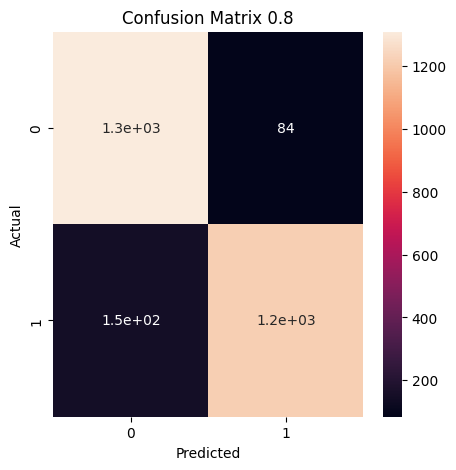

In [50]:
threshold = 0.8
cm = confusion_matrix(labels, predicted > threshold)
#print(cm)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

##ROC Plots##

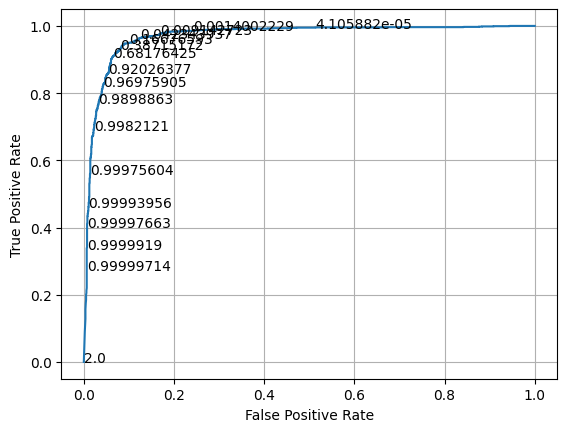

In [49]:
fp, tp, thresholds = roc_curve(labels, predicted)
plt.plot(fp,tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()

skip=25
for i in range(0, len(thresholds), skip):
  plt.text(fp[i],tp[i], thresholds[i])
plt.show()

In [20]:
def infected_or_not(x):
  if(x<0.5):
    return str('I')
  else:
    return str('U')

1/1 [==============================] - 0s 31ms/step


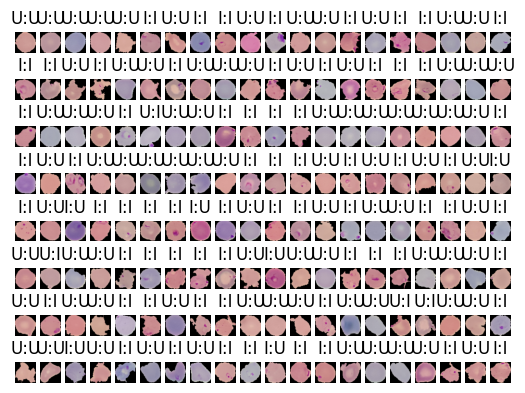

In [21]:
for i,(image,label) in enumerate(test_dataset.take(160)):
  plt.subplot(8,20,i+1)
  plt.imshow(image[0])
  plt.title(str(infected_or_not(label.numpy()[0])) + ':' +str(infected_or_not(lenet_custom_model.predict(image)[0][0])))
  plt.axis('off')